# Tutorial - Step2 : MTMR finetuning with Reinforcement learning

## 1. Import requirements

In [1]:
import os
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
from MTMR.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from MTMR.vae import SmilesAutoencoder, RewardFunction
from MTMR.properties import drd2, qed, similarity

## 2. Configure GPU (if available)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [4]:
PROPERTY_NAME = "qed"

SCORING_PROPERTY_FT = qed
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.75
threshold_similarity = 0.3

## 4. Set directories (for inputs and outputs)¶

In [5]:
input_data_dir = os.path.join("DATA", PROPERTY_NAME)
input_ckpt_dir = os.path.join("outputs_Tutorial_1_MTMR_pretraining", PROPERTY_NAME)

In [6]:
_output_dir = "outputs_Tutorial_2_MTMR_finetuning"
if not os.path.exists(_output_dir):
    os.mkdir(_output_dir)

output_dir = os.path.join(_output_dir, PROPERTY_NAME)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [8]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of MTMR

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [12]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Train

In [13]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         scoring_ft=SCORING_PROPERTY_FT,
                                                         checkpoint_filepath=filepath_checkpoint)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000000/002000]  loss: 0.040  reward: 0.499  similarity: 0.612  property: 0.818  valid_ratio(va): 0.997  similarity(va): 0.403  property(va): 0.754
[000010/002000]  loss: 0.036  reward: 0.514  similarity: 0.635  property: 0.819  valid_ratio(va): 1.000  similarity(va): 0.414  property(va): 0.772
[000020/002000]  loss: 0.037  reward: 0.561  similarity: 0.633  property: 0.827  valid_ratio(va): 1.000  similarity(va): 0.404  property(va): 0.774
[000030/002000]  loss: 0.040  reward: 0.573  similarity: 0.595  property: 0.837  valid_ratio(va): 0.997  similarity(va): 0.407  property(va): 0.793
[000040/002000]  loss: 0.041  reward: 0.616  similarity: 0.569  property: 0.842  valid_ratio(va): 1.000  similarity(va): 0.399  property(va): 0.795
[000050/002000]  loss: 0.043  reward: 0.592  similarity: 0.559  property: 0.843  valid_ratio(va): 1.000  similarity(va): 0.398  property(va): 0.799
[000060/002000]  loss: 0.042  reward: 0.648  similarity: 0.536  property: 0.853  valid_ratio(va): 1.000  similar

[000560/002000]  loss: 0.043  reward: 0.716  similarity: 0.503  property: 0.865  valid_ratio(va): 1.000  similarity(va): 0.369  property(va): 0.841
[000570/002000]  loss: 0.043  reward: 0.723  similarity: 0.486  property: 0.870  valid_ratio(va): 1.000  similarity(va): 0.381  property(va): 0.845
[000580/002000]  loss: 0.048  reward: 0.738  similarity: 0.486  property: 0.873  valid_ratio(va): 1.000  similarity(va): 0.361  property(va): 0.849
[000590/002000]  loss: 0.043  reward: 0.716  similarity: 0.483  property: 0.868  valid_ratio(va): 1.000  similarity(va): 0.366  property(va): 0.835
[000600/002000]  loss: 0.045  reward: 0.728  similarity: 0.502  property: 0.873  valid_ratio(va): 1.000  similarity(va): 0.369  property(va): 0.840
[000610/002000]  loss: 0.041  reward: 0.751  similarity: 0.502  property: 0.873  valid_ratio(va): 1.000  similarity(va): 0.362  property(va): 0.843
[000620/002000]  loss: 0.038  reward: 0.751  similarity: 0.525  property: 0.872  valid_ratio(va): 1.000  similar

[001120/002000]  loss: 0.041  reward: 0.759  similarity: 0.497  property: 0.875  valid_ratio(va): 1.000  similarity(va): 0.362  property(va): 0.856
[001130/002000]  loss: 0.043  reward: 0.769  similarity: 0.501  property: 0.879  valid_ratio(va): 1.000  similarity(va): 0.361  property(va): 0.854
[001140/002000]  loss: 0.042  reward: 0.770  similarity: 0.475  property: 0.879  valid_ratio(va): 1.000  similarity(va): 0.366  property(va): 0.858
[001150/002000]  loss: 0.039  reward: 0.736  similarity: 0.498  property: 0.872  valid_ratio(va): 1.000  similarity(va): 0.358  property(va): 0.858
[001160/002000]  loss: 0.043  reward: 0.778  similarity: 0.491  property: 0.880  valid_ratio(va): 1.000  similarity(va): 0.357  property(va): 0.855
[001170/002000]  loss: 0.040  reward: 0.752  similarity: 0.485  property: 0.876  valid_ratio(va): 1.000  similarity(va): 0.361  property(va): 0.854
[001180/002000]  loss: 0.044  reward: 0.696  similarity: 0.510  property: 0.866  valid_ratio(va): 1.000  similar

[001680/002000]  loss: 0.045  reward: 0.805  similarity: 0.460  property: 0.887  valid_ratio(va): 1.000  similarity(va): 0.355  property(va): 0.856
[001690/002000]  loss: 0.040  reward: 0.741  similarity: 0.482  property: 0.876  valid_ratio(va): 1.000  similarity(va): 0.353  property(va): 0.857
[001700/002000]  loss: 0.039  reward: 0.774  similarity: 0.489  property: 0.878  valid_ratio(va): 1.000  similarity(va): 0.349  property(va): 0.858
[001710/002000]  loss: 0.039  reward: 0.766  similarity: 0.505  property: 0.877  valid_ratio(va): 1.000  similarity(va): 0.359  property(va): 0.857
[001720/002000]  loss: 0.045  reward: 0.790  similarity: 0.494  property: 0.881  valid_ratio(va): 1.000  similarity(va): 0.359  property(va): 0.860
[001730/002000]  loss: 0.042  reward: 0.786  similarity: 0.492  property: 0.882  valid_ratio(va): 1.000  similarity(va): 0.362  property(va): 0.861
[001740/002000]  loss: 0.041  reward: 0.778  similarity: 0.520  property: 0.883  valid_ratio(va): 1.000  similar

## 10. Visualize for reward & loss analysis

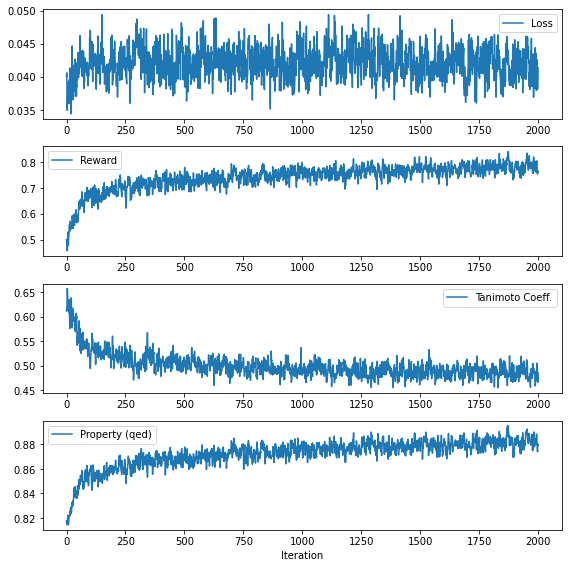

In [14]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

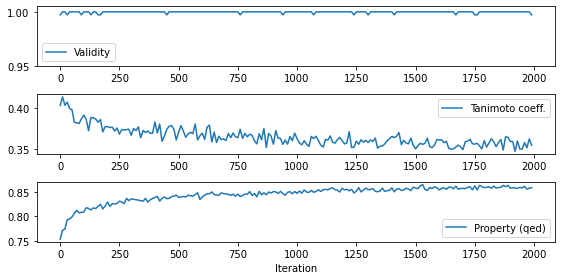

In [21]:
fig, axes = plt.subplots(3,1,figsize=(8,4))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()